## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [3]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [4]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [5]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [6]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [7]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [8]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [9]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [10]:
tmp = pd.DataFrame(X_train.isnull().mean())
tmp.columns = ['value']
tmp[tmp['value'] > 0]

,value
LotFrontage,0.177321
Alley,0.938356
MasVnrType,0.004566
MasVnrArea,0.004566
BsmtQual,0.024353
BsmtCond,0.024353
BsmtExposure,0.025114
BsmtFinType1,0.024353
BsmtFinType2,0.025114
Electrical,0.000761


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11891E30>,
      dtype=object)

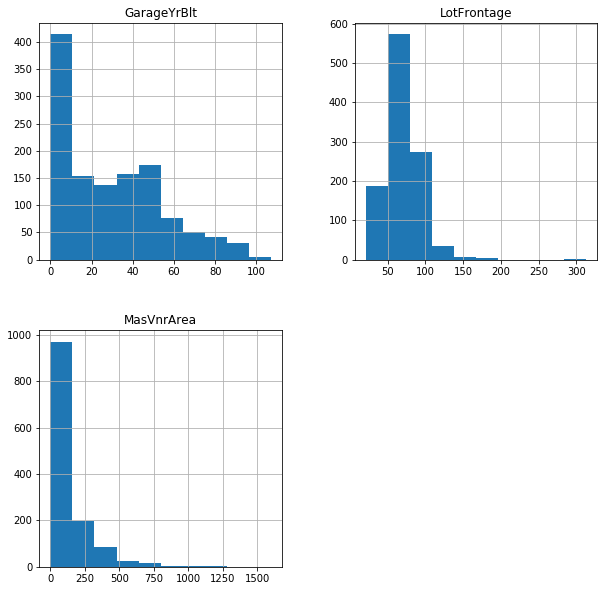

In [11]:
X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(figsize=(10,10))

In [12]:
X_train[numerical].min()> 0

LotFrontage       True
LotArea           True
MasVnrArea       False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtUnfSF        False
TotalBsmtSF      False
1stFlrSF          True
2ndFlrSF         False
LowQualFinSF     False
GrLivArea         True
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
MiscVal          False
dtype: bool

In [13]:
numerical_pos = [var for var in numerical if X_train[var].min()>0]
numerical_pos

['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']

In [25]:
numerical_neg = [var for var in numerical if var not in numerical_pos]
type(numerical_neg)
type(numerical)

list

In [29]:
numerical

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [15]:
from feature_engine import variable_transformers as vt
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

In [30]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddNaNBinaryImputer(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical_neg)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical_neg)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [34]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddNaNBinaryImputer(
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),
    
    
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.05,
                                    n_categories=6,
                                    variables=categorical + discrete)),
    ('categorical_enc',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=categorical + discrete)),

    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=5,
                                   return_object=True,
                                   variables=numerical_neg)),
    ('Encoding',
    ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical_neg)),
    # Box-Cox
    ('BoxCoxTransform',
    vt.BoxCoxTransformer(variables = numerical_pos)),
    
#     ('encoding',
#      ce.OrdinalCategoricalEncoder(encoding_method='ordered',
#                                   variables=numerical_pos)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [18]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition
930,20,RL,73.0,8925,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,7,WD,Normal
656,20,RL,72.0,10007,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,MnPrv,NaN,0,8,WD,Normal
45,120,RL,61.0,7658,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,2,WD,Normal
1348,20,RL,NaN,16196,Pave,NaN,IR3,Low,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,8,WD,Normal
55,20,RL,100.0,10175,Pave,NaN,IR1,Lvl,AllPub,Inside,...,407,0,0,NaN,NaN,NaN,0,7,WD,Normal
1228,120,RL,65.0,8769,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,224,0,NaN,NaN,NaN,0,10,New,Partial
963,20,RL,122.0,11923,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,NaN,NaN,0,5,WD,Normal
921,90,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,GdPrv,NaN,0,9,WD,Normal
458,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,0,NaN,MnPrv,NaN,0,6,WD,Normal
1386,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,440,519,Fa,MnPrv,TenC,2000,7,WD,Normal


In [35]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

c:\program files (x86)\python37-32\lib\site-packages\scipy\stats\morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
c:\program files (x86)\python37-32\lib\site-packages\scipy\optimize\optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
c:\program files (x86)\python37-32\lib\site-packages\scipy\optimize\optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
c:\program files (x86)\python37-32\lib\site-packages\scipy\optimize\optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
c:\program files (x86)\python37-32\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\program fil

In [36]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 987718024.2463056
train rmse: 31427.981549032156
train r2: 0.8418089974601012

test mse: 1827442201.615626
test rmse: 42748.59297819785
test r2: 0.7340786460370188


Text(0, 0.5, 'Predicted Price')

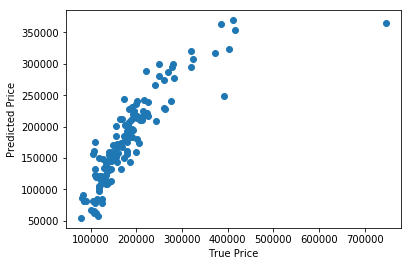

In [37]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

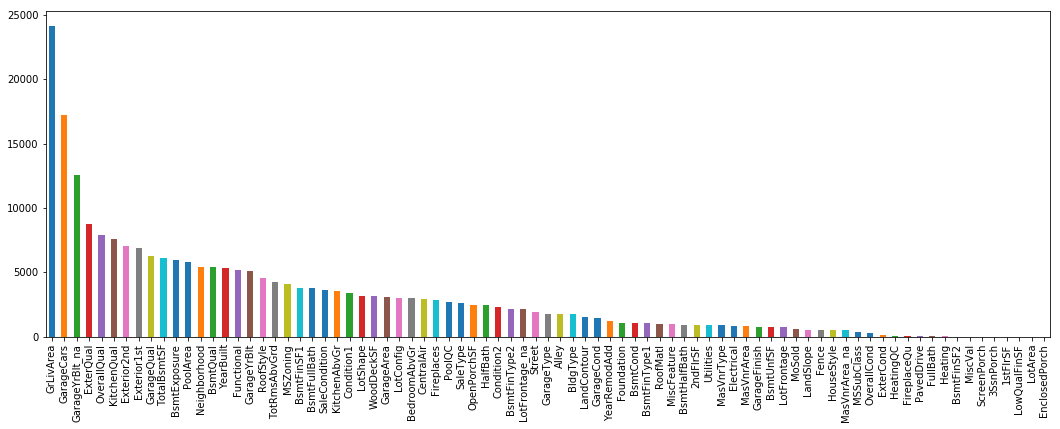

In [38]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))